<a href="https://colab.research.google.com/github/prado3003/cat-vs-dogs-ML/blob/main/cats_vs_dogs_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [2]:
!echo "Downloading cats_vs_dogs for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar https://www.microsoft.com/en-us/download/details.aspx?id=54765
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls


######################################################################## 100.0%

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now
sample_data


In [3]:
!echo "Downloading cats_vs_dogs for image notebooks"
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip kagglecatsanddogs_5340.zip
!rm kagglecatsanddogs_5340.zip
!ls

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  
  inflating: PetImages/Dog/55

In [4]:
root = 'PetImages'
train_split, val_split = 0.7, 0.15

exclude = []
categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['PetImages/Dog', 'PetImages/Cat']


In [5]:
def data_generator(cat_images, dog_images, batch_size):
    while True:
        # combine and shuffle the data
        all_images = cat_images + dog_images
        labels = [0] * len(cat_images) + [1] * len(dog_images)
        combined = list(zip(all_images, labels))
        random.shuffle(combined)
        all_images, labels = zip(*combined)

        # create batches
        for i in range(0, len(all_images), batch_size):
            batch_images = all_images[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            # load and preprocess images
            x, y = [], []
            for img_path, label in zip(batch_images, batch_labels):
                try:
                    img = image.load_img(img_path, target_size=(224, 224))
                    img = image.img_to_array(img)
                    img = preprocess_input(img)
                    x.append(img)
                    y.append(label)
                except Exception as e:
                    print(f"Error loading image: {img_path}, error: {e}")

            yield np.array(x), keras.utils.to_categorical(y, num_classes=2)

In [6]:
from keras.applications.vgg16 import VGG16

# get the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# add new classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# print the model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,407,874 (154.14 MB)

 Trainable params: 25,693,186 (98.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Helper function to get full image paths
def get_image_paths(category_folder):
    image_paths = []
    for root_dir, _, filenames in os.walk(category_folder):
        for filename in filenames:
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root_dir, filename))
    return image_paths

# Get all image paths for cats and dogs
all_cat_images = get_image_paths(os.path.join(root, 'Cat'))
all_dog_images = get_image_paths(os.path.join(root, 'Dog'))

# Shuffle the image lists
random.shuffle(all_cat_images)
random.shuffle(all_dog_images)

# Define split ratios
train_split = 0.7
val_split = 0.15

# Split cat images
train_cat_images = all_cat_images[:int(len(all_cat_images) * train_split)]
val_cat_images = all_cat_images[int(len(all_cat_images) * train_split):int(len(all_cat_images) * (train_split + val_split))]

# Split dog images
train_dog_images = all_dog_images[:int(len(all_dog_images) * train_split)]
val_dog_images = all_dog_images[int(len(all_dog_images) * train_split):int(len(all_dog_images) * (train_split + val_split))]


batch_size = 32
epochs = 10

# create the data generators
train_generator = data_generator(train_cat_images, train_dog_images, batch_size)
val_generator = data_generator(val_cat_images, val_dog_images, batch_size)

# calculate the number of steps per epoch
steps_per_epoch = (len(train_cat_images) + len(train_dog_images)) // batch_size
validation_steps = (len(val_cat_images) + len(val_dog_images)) // batch_size

# train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
221/546 ━━━━━━━━━━━━━━━━━━━━ 51s 159ms/step - accuracy: 0.9230 - loss: 11.1646Error loading image: PetImages/Dog/11702.jpg, error: cannot identify image file <_io.BytesIO object at 0x7d96bffcb650>
471/546 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.9433 - loss: 7.3189Error loading image: PetImages/Cat/666.jpg, error: cannot identify image file <_io.BytesIO object at 0x7d96a19ba070>
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9464 - loss: 6.7014

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


546/546 ━━━━━━━━━━━━━━━━━━━━ 137s 225ms/step - accuracy: 0.9465 - loss: 6.6940 - val_accuracy: 0.9728 - val_loss: 0.4430
Epoch 2/10
335/546 ━━━━━━━━━━━━━━━━━━━━ 35s 169ms/step - accuracy: 0.9849 - loss: 0.1929Error loading image: PetImages/Cat/666.jpg, error: cannot identify image file <_io.BytesIO object at 0x7d96eae2ce50>
355/546 ━━━━━━━━━━━━━━━━━━━━ 32s 169ms/step - accuracy: 0.9849 - loss: 0.1926Error loading image: PetImages/Dog/11702.jpg, error: cannot identify image file <_io.BytesIO object at 0x7d96eae2e3e0>
546/546 ━━━━━━━━━━━━━━━━━━━━ 141s 239ms/step - accuracy: 0.9848 - loss: 0.1898 - val_accuracy: 0.9752 - val_loss: 0.4104
Epoch 3/10
183/546 ━━━━━━━━━━━━━━━━━━━━ 1:03 174ms/step - accuracy: 0.9871 - loss: 0.1769Error loading image: PetImages/Cat/666.jpg, error: cannot identify image file <_io.BytesIO object at 0x7d96e8772e30>
511/546 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.9873 - loss: 0.1757Error loading image: PetImages/Dog/11702.jpg, error: cannot identify image 

In [10]:
import os
from PIL import Image
import time

def check_and_remove_corrupted_images(directory_path):
    print(f"Checking directory: {directory_path}")
    corrupted_count = 0
    total_files = 0
    for filename in os.listdir(directory_path):
        total_files += 1
        filepath = os.path.join(directory_path, filename)
        if not os.path.isfile(filepath):
            continue
        try:
            with Image.open(filepath) as img:
                img.verify()
        except (IOError, SyntaxError) as e:
            print(f"  - Corrupted image found: {filename}. Deleting...")
            os.remove(filepath)
            corrupted_count += 1
    print(f"Finished checking {total_files} files. Found and removed {corrupted_count} corrupted images.\n")

# Paths to the Cat and Dog directories
cat_dir = os.path.join(root, 'Cat')
dog_dir = os.path.join(root, 'Dog')

# Clean the directories
check_and_remove_corrupted_images(cat_dir)
time.sleep(1) # Small delay
check_and_remove_corrupted_images(dog_dir)

print("Dataset cleaning complete.")

Checking directory: PetImages/Cat
  - Corrupted image found: 666.jpg. Deleting...
  - Corrupted image found: Thumbs.db. Deleting...
Finished checking 12501 files. Found and removed 2 corrupted images.

Checking directory: PetImages/Dog


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  - Corrupted image found: 11702.jpg. Deleting...
  - Corrupted image found: Thumbs.db. Deleting...
Finished checking 12501 files. Found and removed 2 corrupted images.

Dataset cleaning complete.


In [11]:
# Re-split the data after cleaning to ensure our lists are up-to-date
all_cat_images = get_image_paths(os.path.join(root, 'Cat'))
all_dog_images = get_image_paths(os.path.join(root, 'Dog'))

random.shuffle(all_cat_images)
random.shuffle(all_dog_images)

train_cat_images = all_cat_images[:int(len(all_cat_images) * train_split)]
val_cat_images = all_cat_images[int(len(all_cat_images) * train_split):int(len(all_cat_images) * (train_split + val_split))]

train_dog_images = all_dog_images[:int(len(all_dog_images) * train_split)]
val_dog_images = all_dog_images[int(len(all_dog_images) * train_split):int(len(all_dog_images) * (train_split + val_split))]

# Now, let's create the generators and train
batch_size = 32
epochs = 10

train_generator = data_generator(train_cat_images, train_dog_images, batch_size)
val_generator = data_generator(val_cat_images, val_dog_images, batch_size)

steps_per_epoch = (len(train_cat_images) + len(train_dog_images)) // batch_size
validation_steps = (len(val_cat_images) + len(val_dog_images)) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
255/546 ━━━━━━━━━━━━━━━━━━━━ 47s 164ms/step - accuracy: 0.9864 - loss: 1.1349

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


546/546 ━━━━━━━━━━━━━━━━━━━━ 111s 202ms/step - accuracy: 0.9868 - loss: 1.0053 - val_accuracy: 0.9931 - val_loss: 0.1555
Epoch 2/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 122s 204ms/step - accuracy: 0.9902 - loss: 0.2760 - val_accuracy: 0.9928 - val_loss: 0.1590
Epoch 3/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 111s 204ms/step - accuracy: 0.9897 - loss: 0.3069 - val_accuracy: 0.9946 - val_loss: 0.1251
Epoch 4/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - accuracy: 0.9925 - loss: 0.1731 - val_accuracy: 0.9952 - val_loss: 0.1731
Epoch 5/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 112s 205ms/step - accuracy: 0.9919 - loss: 0.3202 - val_accuracy: 0.9938 - val_loss: 0.4619
Epoch 6/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 111s 204ms/step - accuracy: 0.9918 - loss: 0.4853 - val_accuracy: 0.9944 - val_loss: 0.2136
Epoch 7/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - accuracy: 0.9951 - loss: 0.1304 - val_accuracy: 0.9941 - val_loss: 0.1717
Epoch 8/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - accuracy: 0.9924 - loss: 0.25

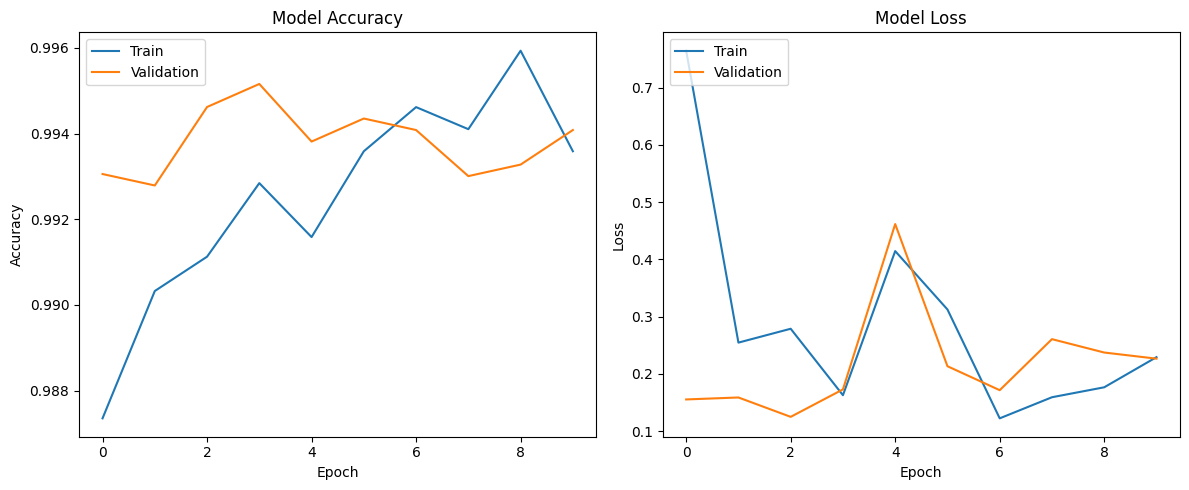

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


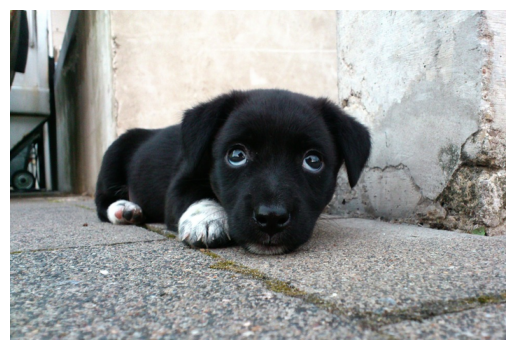

Prediction array: [[0. 1.]]
Resultado: É um Cachorro!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


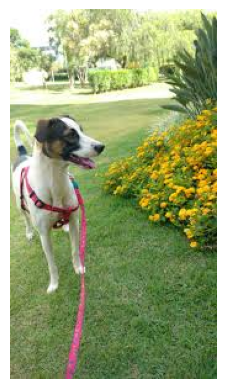

Prediction array: [[0. 1.]]
Resultado: É um Cachorro!


In [19]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input


def predict_image_from_url(url):
    try:
        # Baixar a imagem da URL
        response = requests.get(url)
        response.raise_for_status() # Lança um erro para status HTTP ruins

        # Carregar a imagem a partir dos dados baixados
        img = Image.open(BytesIO(response.content)).convert("RGB")

        # Pré-processar a imagem para o modelo
        img_resized = img.resize((224, 224))
        img_array = image.img_to_array(img_resized)
        img_array_expanded = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_array_expanded)

        # Fazer a previsão
        prediction = model.predict(img_preprocessed)

        # Mostrar a imagem e o resultado
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        print(f"Prediction array: {prediction}")
        # A classe 0 é 'Gato' e a classe 1 é 'Cachorro'
        if prediction[0][0] > prediction[0][1]:
            print("Resultado: É um Gato!")
        else:
            print("Resultado: É um Cachorro!")

    except requests.exceptions.RequestException as e:
        print(f"Erro ao baixar a imagem: {e}")
    except Exception as e:
        print(f"Ocorreu um erro ao processar a imagem: {e}")

# --- COLOQUE UMA URL DE IMAGEM DIRETA AQUI ---
# Exemplo de URL direta de um cachorro
image_url = "https://blog.cobasi.com.br/wp-content/uploads/2021/08/vira-lata-filhote-2.png"
predict_image_from_url(image_url)

print("\n" + "="*30 + "\n")

# --- PODE TESTAR OUTRA IMAGEM AQUI ---
# Exemplo de URL direta de um gato
image_url_2 = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQH6ABJMlb4ikEOErfHEO6n_E0dmKsRSZqRtw&s"
predict_image_from_url(image_url_2)